# Customer Segmentation Report

In [1]:
%matplotlib inline
import pickle
import itertools
from itertools import chain
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Import Data

In [2]:
# load the local dataset 
df = pd.read_csv('../data/adult_dataset.csv')

# Relabel taget colum since there is no target in unsupervised learning
df.rename(columns={"Target": "Income"}, inplace=True)

# Correct the Income column typo
df['Income'] = df['Income'].apply(lambda x: x.replace('.', ''))

df.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


# Load Model Artifacts

In [3]:
with open('../artifacts/numeric_imputer.pickle', 'rb') as filename: # trained model to impute missing numeric data
    numeric_imputer = pickle.load(filename)

with open('../artifacts/categorical_imputer.pickle', 'rb') as filename: # trained model to impute missing categorical data
    categorical_imputer = pickle.load(filename) 

with open('../artifacts/rare_encoder.pickle', 'rb') as filename: # trained model to encode rare labels
    rare_encoder = pickle.load(filename)

with open('../artifacts/capper.pickle', 'rb') as filename: # trained model to cap outliers
    capper = pickle.load(filename)   

with open('../artifacts/enc.pickle', 'rb') as filename: # trained one hot encoder
    enc = pickle.load(filename)

with open('../artifacts/model.pickle', 'rb') as filename: # trained random forrest classifier
    model = pickle.load(filename)

# Transform Dataset

In [4]:
# get numeric and categorical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = df.select_dtypes(include=numerics).columns.to_list()
categorical_columns = df.select_dtypes(exclude=numerics).columns.to_list()

In [5]:
# impute mising numeric features
df_numeric = pd.DataFrame(
    numeric_imputer.transform(df[numeric_columns]), 
    columns=numeric_columns, 
    index=df.index)

# impute mising categorical features
df_categorical = pd.DataFrame(
    categorical_imputer.transform(df[categorical_columns]), 
    columns=categorical_columns, 
    index=df.index)

# concate numeric and categorical features
df = pd.concat([df_numeric, df_categorical], axis=1)

# remove rare labels
df[categorical_columns] = rare_encoder.transform(df[categorical_columns])

# remove outliers
df[numeric_columns] = capper.transform(df[numeric_columns])

# one hot encoding categorical features
df_cat_hotenc = pd.DataFrame(
    enc.transform(df[categorical_columns]), 
    columns=enc.get_feature_names_out(),
    index=df.index) 

# concate numeric and hot-encoded categorical features
df_hotenc = pd.concat([df[numeric_columns], df_cat_hotenc], axis=1)

# predict cluster
labels = model.predict(df_hotenc)

# add cluster label to df
df['cluster'] = labels

df.head()

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income,cluster
0,39.0,77516.0,13.0,2174.0,0.0,40.0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K,0
1,50.0,83311.0,13.0,0.0,0.0,13.0,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K,0
2,38.0,215646.0,9.0,0.0,0.0,40.0,Private,HS-grad,Divorced,Rare,Not-in-family,White,Male,United-States,<=50K,2
3,53.0,234721.0,7.0,0.0,0.0,40.0,Private,Rare,Married-civ-spouse,Rare,Husband,Black,Male,United-States,<=50K,0
4,28.0,338409.0,13.0,0.0,0.0,40.0,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Rare,<=50K,0


# Data Visualization

In [6]:
# Cluster Counts
df['cluster'].value_counts()

0    27198
1    12208
2     8246
3     1190
Name: cluster, dtype: int64

## What does the Cluster Distribution Lool Like?

In [7]:
# Cluster Counts
cluster_labels = []
for c in df['cluster'].value_counts().index.tolist():
    if c == 0:
        label = 'Noise Cluster'
    else:
        label = 'Cluster ' + str(c)
    cluster_labels.append(label)

cluster_labels

['Noise Cluster', 'Cluster 1', 'Cluster 2', 'Cluster 3']

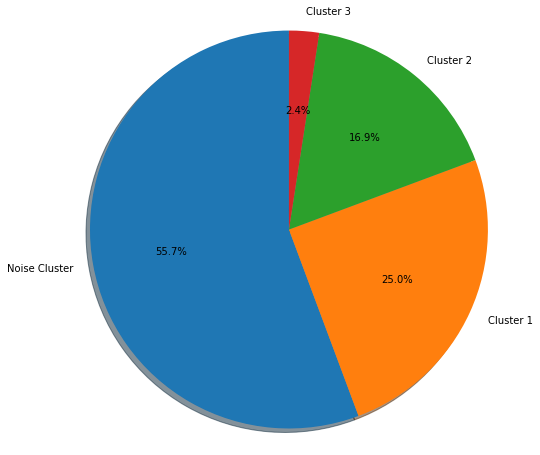

In [8]:
labels = cluster_labels
sizes = df['cluster'].value_counts().to_list()
explode = (0, 0, 0, 0)  

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(
    x=sizes, 
    explode=explode, 
    labels=labels, 
    autopct='%1.1f%%',
    shadow=True, 
    startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Determine Cluster Centers

In [9]:
# Cluster Centers
pd.concat([
    df.groupby(by='cluster').mean(),
    df.groupby(by='cluster').aggregate(pd.Series.mode)[categorical_columns] ],
    axis=1)


,Age,fnlwgt,Education-Num,Capital Gain,Capital Loss,Hours per week,Workclass,Education,Martial Status,Occupation,Relationship,Race,Sex,Country,Income
cluster,,,,,,,,,,,,,,,
0,40.911580,192300.261221,10.287227,806.467609,77.508181,40.389680,Private,Rare,Married-civ-spouse,Exec-managerial,Not-in-family,White,Male,United-States,<=50K
1,42.688991,180531.280159,9.951016,851.457887,42.345697,43.643237,Private,HS-grad,Married-civ-spouse,Craft-repair,Husband,White,Male,United-States,<=50K
2,26.558951,186843.276619,9.152559,78.423230,27.467518,35.059433,Private,HS-grad,Never-married,Rare,Own-child,White,Male,United-States,<=50K
3,28.379832,188394.921701,13.015126,110.082353,48.792694,40.818258,Private,Bachelors,Never-married,Exec-managerial,Not-in-family,White,Female,United-States,<=50K


# Explain Clusters

In [10]:
# Tree Explainer
explainer = shap.TreeExplainer(
    model = model.best_estimator_,
    output = 'probability')

# get random sample
X = df_hotenc.sample(1000)

# calculate shap values
shap_values = explainer.shap_values(X)

# Custom Functions

In [11]:
def get_top_cluster_features(shap_values, cluster=0, topn=5):
    """Get top n features for given cluster"""
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()
    return topn_features

def plot_cluster_feature_importance(shap_values, cluster=0, topn=5):
    """Barplot feature importance for specific cluster"""
    fig = plt.figure(figsize=(10,6))
    shap_values_df = pd.DataFrame(
        data=shap_values[cluster],
        columns=X.columns
    )

    shap_values_df_topn = shap_values_df.abs().mean().sort_values(ascending=True)[-topn:]
    topn_features = shap_values_df_topn.index[::-1].to_list()

    # get most important top n
    plt.barh(
        width=shap_values_df_topn, 
        y=shap_values_df_topn.index
    )
    plt.title('Feature Importance for Cluster {}'.format(cluster))
    plt.xlabel('mean(|shap value|)')
    #plt.xlim(-.1,.4)
    plt.show()

def plot_cluster_shap_values(shap_values, cluster=0, topn=5):
    """Violin plot of the shap values for cluster"""
    shap.summary_plot(
        shap_values = shap_values[cluster], 
        features = X,
        sort=True,
        plot_size=(12.0,6.0),
        show=False,
        max_display=topn,
        plot_type='violin'
        )
    ax=plt.gca()
    ax.set_title('Shap Feature Importance for Cluster {}'.format(cluster))
    ax.grid()
    ax.set_xlim(-.4,.4)
    fig = plt.gcf()
    plt.show()

def jitter(values, loc, scale):
    """Add some jitter for visibility"""
    return values + np.random.normal(loc, scale,values.shape)

## Average Feature Importance on Cluster Building

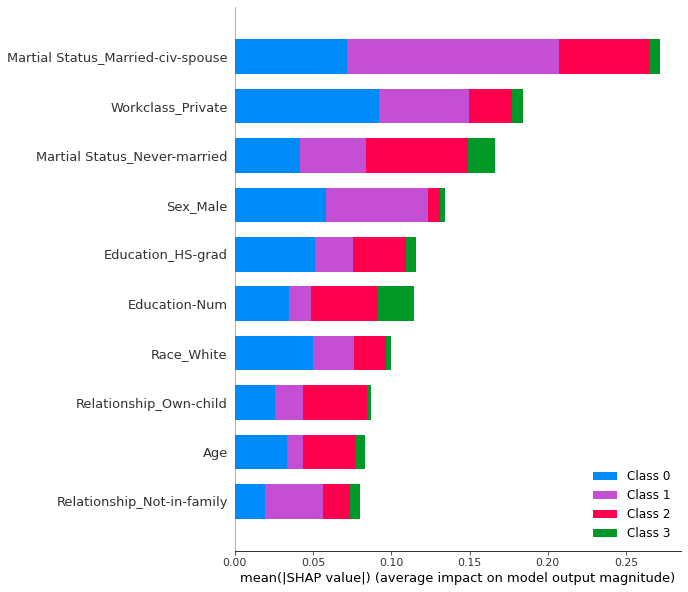

In [12]:
shap.summary_plot(
    shap_values = shap_values, 
    features = X,
    sort=True,
    max_display=10,
    plot_size=(8.0,10.0)
)

## Explain Single Cluster vs Rest

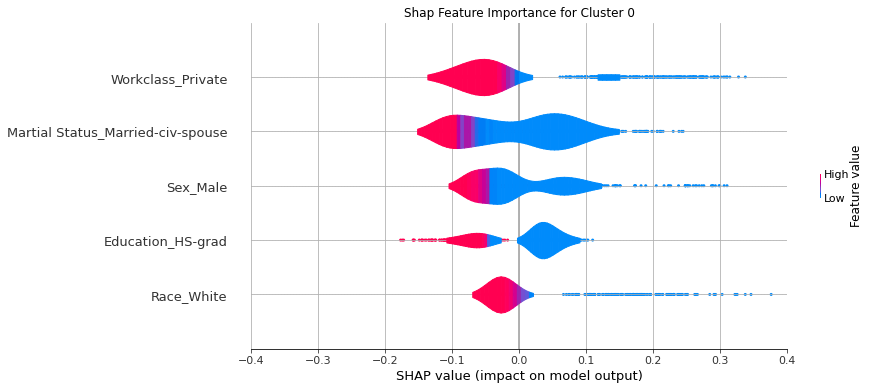

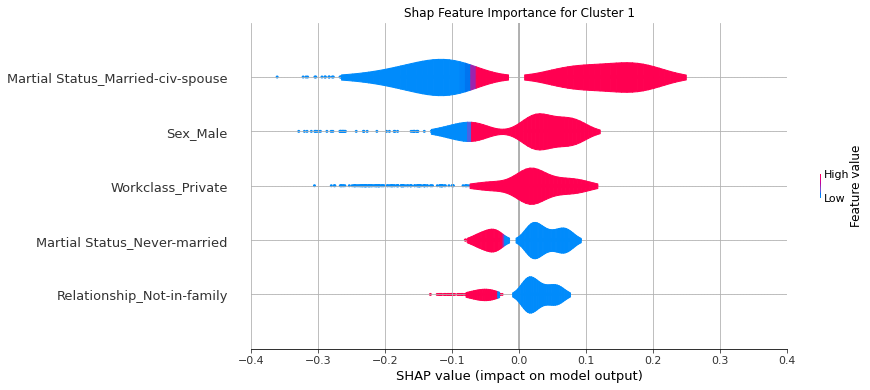

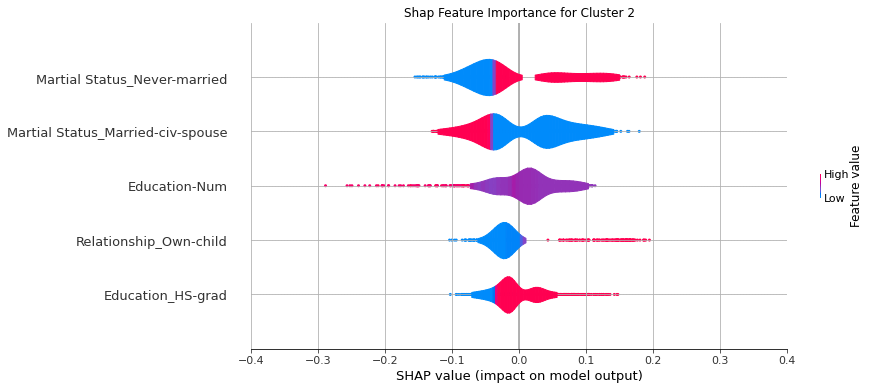

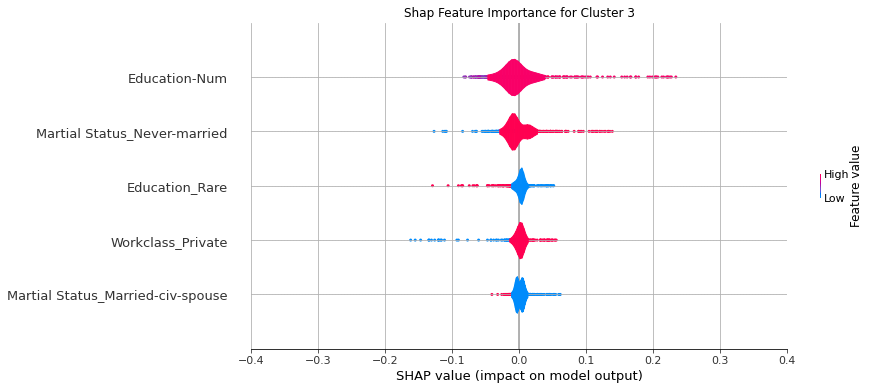

In [13]:
for c in np.sort(df['cluster'].unique()):
    #plot_cluster_feature_importance(
    #    shap_values, 
    #    cluster=c, 
    #    topn=5)
    
    plot_cluster_shap_values(
        shap_values, 
        cluster=c, 
        topn=5)

In [14]:
# get top n features in cluster n
get_top_cluster_features(
    shap_values, 
    cluster=2, 
    topn=5)

['Martial Status_Never-married',
 'Martial Status_Married-civ-spouse',
 'Education-Num',
 'Relationship_Own-child',
 'Education_HS-grad']

In [15]:
# get most important features considering the top n features in each cluster
n=5
array = [get_top_cluster_features(shap_values, cluster=c, topn=n) for c in np.sort(df['cluster'].unique())]
top_features = list(set(chain(*array)))
top_features

['Relationship_Not-in-family',
 'Education_HS-grad',
 'Martial Status_Never-married',
 'Education_Rare',
 'Workclass_Private',
 'Relationship_Own-child',
 'Sex_Male',
 'Martial Status_Married-civ-spouse',
 'Education-Num',
 'Race_White']

In [16]:
# seperate top_features into numerical and categorical features
top_features_num = [feat for feat in top_features if feat not in df_cat_hotenc.columns]
top_features_num

['Education-Num']

In [17]:
top_features_cat = list(set([feat.split('_')[0] for feat in top_features if feat in df_cat_hotenc.columns]))
top_features_cat

['Relationship', 'Martial Status', 'Education', 'Workclass', 'Race', 'Sex']

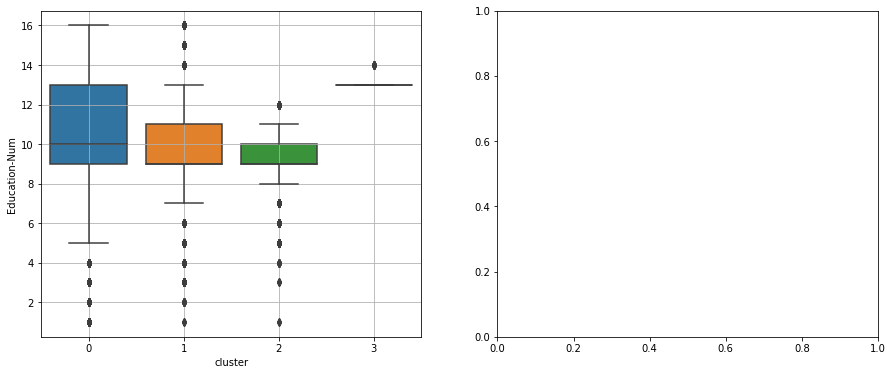

In [18]:
# boxplots for numeric columns
fig, ax = plt.subplots(
        figsize=(15,6), 
        nrows=1, 
        ncols=2, 
        #sharex=True
        )
ax = ax.flatten()


for n, feat in enumerate(top_features_num):
    sns.boxplot(
        data=df,
        x='cluster',
        y=feat,
        whis=1.0,
        ax=ax[n]
    )
    ax[n].grid()
plt.show()

In [19]:
# show number of unique combinations for scatter plotting
len([c for c in itertools.combinations(top_features_num, 2)])

0

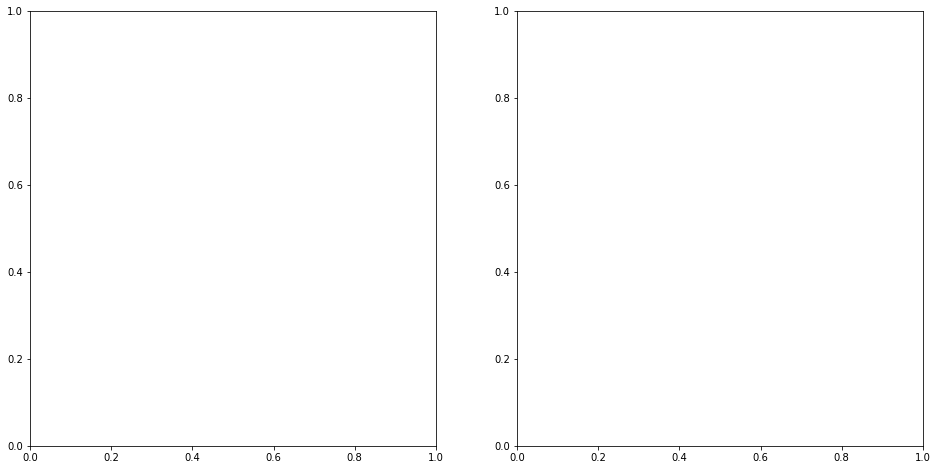

In [20]:
# exclude noise for visibility
data = df[df['cluster']!=0]
#size=[1 if c == 0 else 2 for c in df['cluster']]

fig, ax = plt.subplots(
        figsize=(16,8), 
        nrows=1, 
        ncols=2, 
        #sharex=True
        )
ax = ax.flatten()

for n, c in enumerate(itertools.combinations(top_features_num, 2)):
    x = data[c[0]]
    x_mean = np.mean(x)
    y = data[c[1]]
    y_mean = np.mean(y)

    sns.scatterplot(
        data=data,
        x=jitter(x, 0, 0.1*x_mean),
        y=jitter(y, 0, 0.1*y_mean),
        hue='cluster',
        #hue_order=(1,2,0),
        palette='deep',
        #alpha=.5,
        #size=size,
        ax=ax[n]
    )
    title = str(c).strip('(,)').split(',')
    ax[n].set_title(title[0]+'\n'+title[1])
    ax[n].grid()

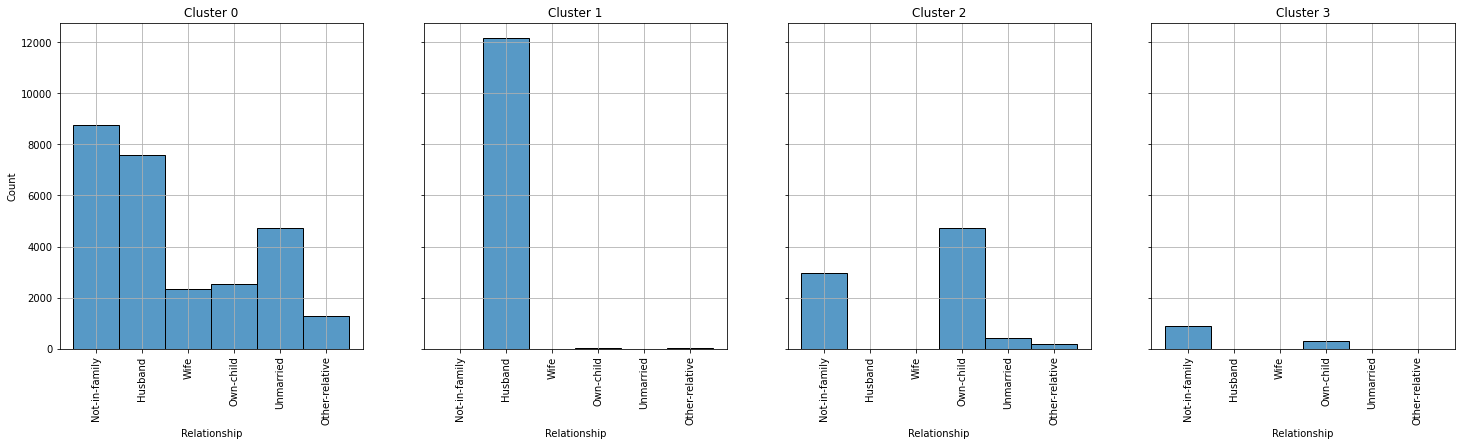

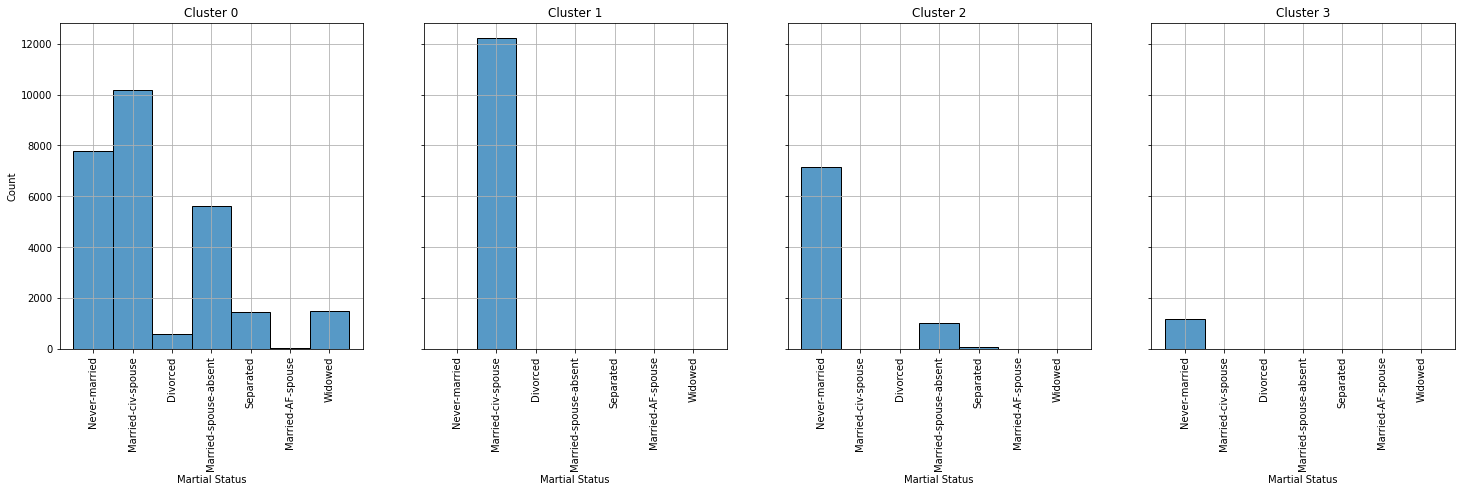

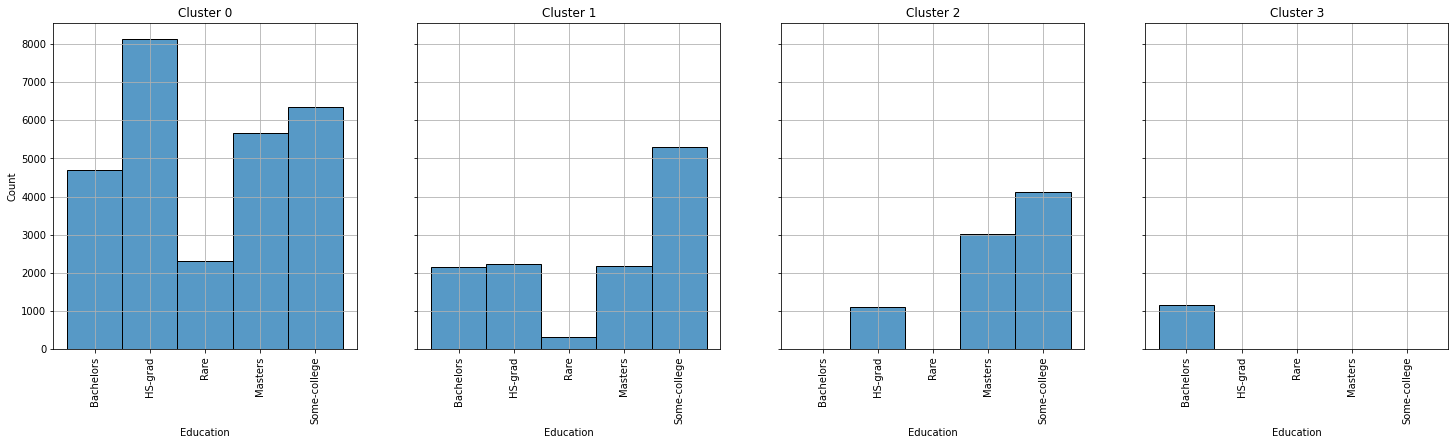

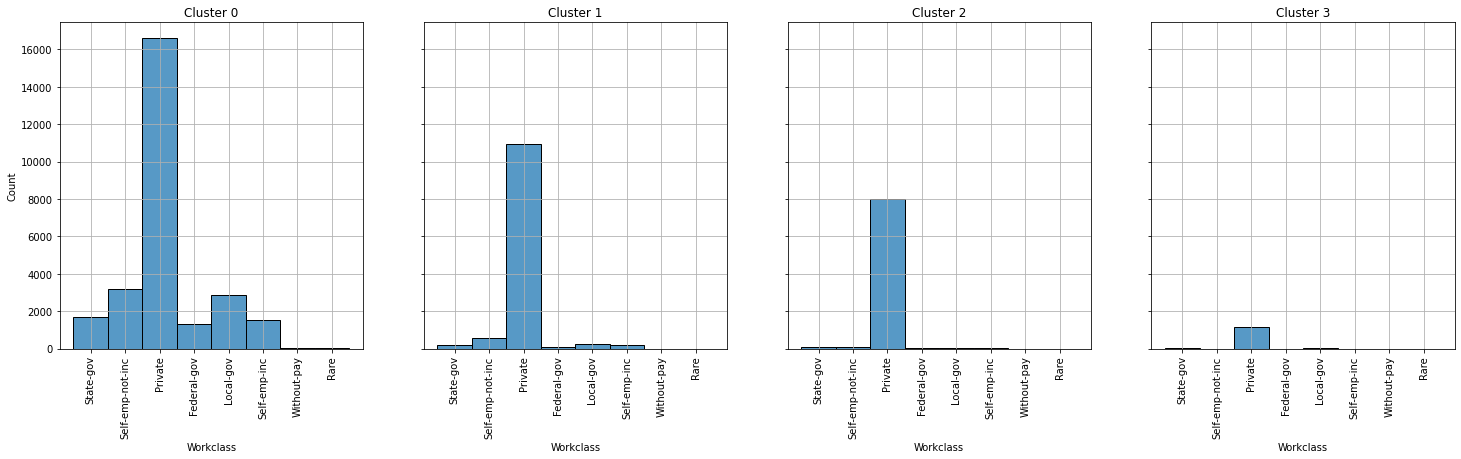

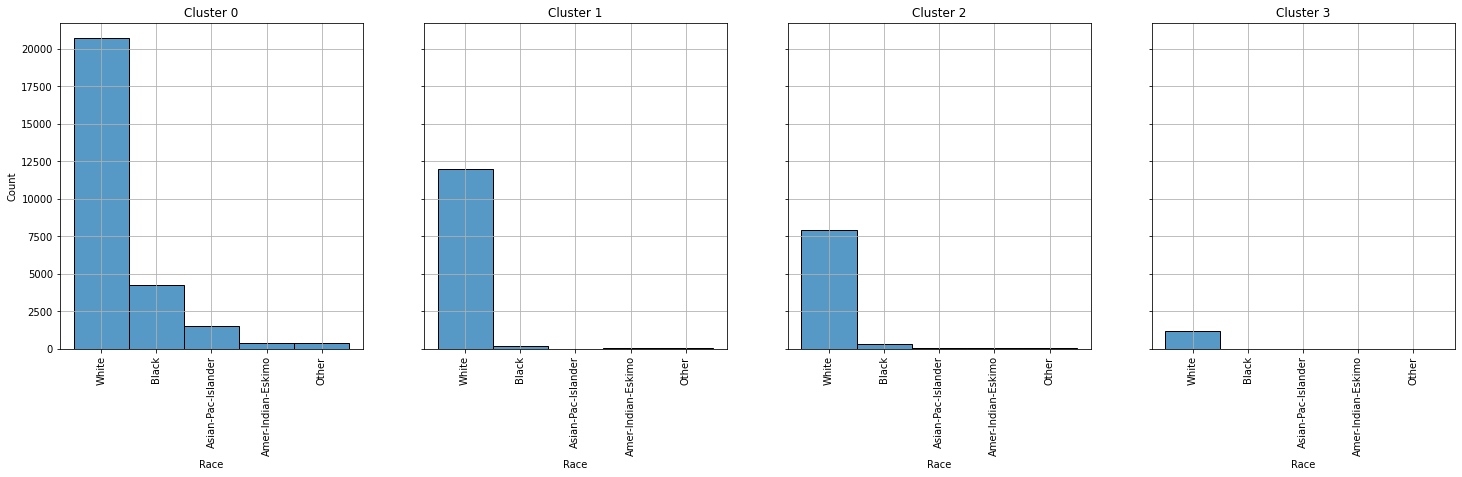

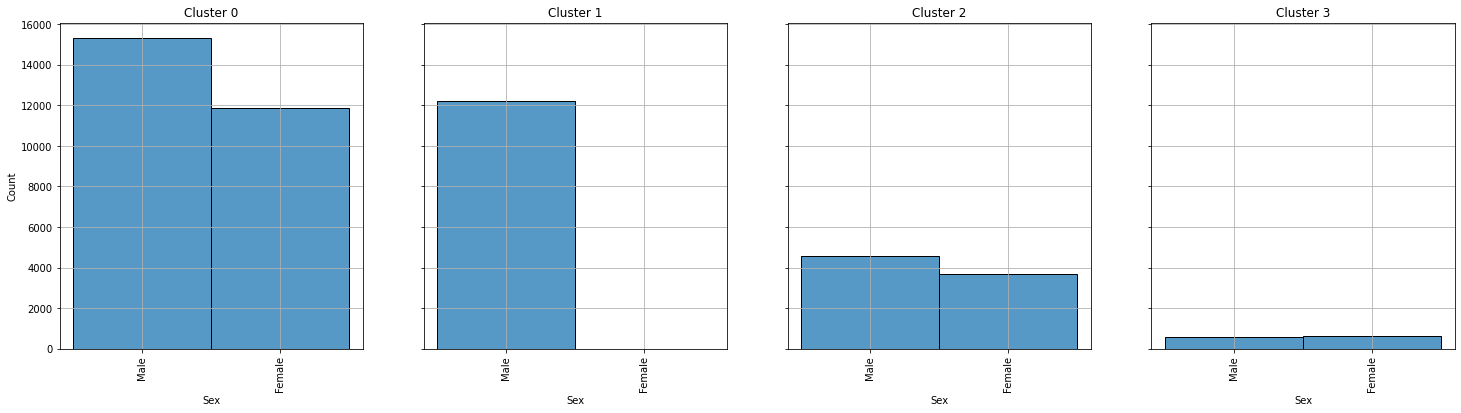

In [21]:
# visualize categorical features for each cluster
for feat in top_features_cat:

    fig, ax = plt.subplots(
        figsize=(25,6), 
        nrows=1, 
        ncols=df['cluster'].nunique(), 
        sharex=True,
        sharey=True)
    
    for c in np.sort(df['cluster'].unique()):

        sns.histplot(
            data=df[df['cluster']==c], 
            x=feat,
            ax=ax[c])    
        ax[c].set_xticks(ax[c].get_xticks(), df[feat].unique(), rotation=90)
        ax[c].set_title('Cluster '+str(c))
        ax[c].grid()
    plt.show()

In [22]:
# Export Notebook as PDF
!jupyter nbconvert  --output-dir='../reports' --to pdf --no-input 06_customer_seg_adultdata_report.ipynb

C:\Users\Nutzer\.conda\envs\customer_analytics\lib\site-packages\traitlets\traitlets.py:2389: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use '../reports' instead of "'../reports'" if you require traitlets >=5.
  warn(
[NbConvertApp] Converting notebook 06_customer_seg_adultdata_report.ipynb to pdf
[NbConvertApp] Support files will be in 06_customer_seg_adultdata_report_files\
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata_report_files
[NbConvertApp] Making directory .\06_customer_seg_adultdata